# Football Win Prediction

The problem is approached as follows:
1. Loading data and analysis
2. Preprocessing
3. Training
4. Prediction
5. Fine tuning

## Loading data and analysis

In [1]:
# import required libs
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import eli5
from eli5.sklearn import PermutationImportance

Using TensorFlow backend.


In [2]:
# load data
def load_data():
    # glancing at data shows Date column and hence the same is parsed
    training_data = pd.read_csv("train.csv", parse_dates=['Date'])
    test_data = pd.read_csv("test-3.csv", parse_dates=['Date'])
    return training_data, test_data

In [3]:
training_data, test_data = load_data()

In [4]:
training_data.head(5)

,AC,AF,AR,AS,AST,AY,AwayTeam,Date,FTR,HC,HF,HR,HS,HST,HTAG,HTHG,HY,HomeTeam,league
0,3.0,12.0,0.0,14.0,4.0,0.0,Stuttgart,2009-07-08,H,6.0,12.0,0.0,13.0,7.0,0.0,0.0,0.0,Wolfsburg,bundesliga
1,1.0,10.0,0.0,7.0,0.0,1.0,FC Koln,2009-08-08,H,16.0,8.0,0.0,24.0,11.0,0.0,0.0,0.0,Dortmund,bundesliga
2,3.0,20.0,0.0,15.0,3.0,2.0,Hannover,2009-08-08,H,5.0,16.0,0.0,10.0,4.0,0.0,0.0,3.0,Hertha,bundesliga
3,10.0,28.0,0.0,9.0,3.0,2.0,Bayern Munich,2009-08-08,D,3.0,10.0,0.0,9.0,1.0,1.0,1.0,0.0,Hoffenheim,bundesliga
4,5.0,28.0,0.0,13.0,7.0,2.0,Leverkusen,2009-08-08,D,3.0,22.0,0.0,8.0,4.0,2.0,1.0,1.0,Mainz,bundesliga


In [5]:
test_data.head(5)

,index,AC,AF,AR,AS,AST,AY,AwayTeam,Date,HC,HF,HR,HS,HST,HTAG,HTHG,HY,HomeTeam,Referee,league
0,0,5,17,0,19,4,2,Leverkusen,2017-08-18,4,13,0,13,8,0,2,1,Bayern Munich,NaN,bundesliga
1,1,7,16,0,13,1,3,Augsburg,2017-08-19,3,18,0,11,5,0,1,4,Hamburg,NaN,bundesliga
2,2,1,12,0,9,2,1,Stuttgart,2017-08-19,5,18,0,10,3,0,0,2,Hertha,NaN,bundesliga
3,3,4,15,0,11,2,3,Werder Bremen,2017-08-19,6,17,0,14,3,0,0,1,Hoffenheim,NaN,bundesliga
4,4,1,14,0,6,2,5,Hannover,2017-08-19,13,18,0,14,6,0,0,3,Mainz,NaN,bundesliga


In [6]:
pd.unique(training_data.FTR)

array(['H', 'D', 'A', nan], dtype=object)

In [7]:
# there are 7 records which are meaningless
training_data.query('FTR not in ("H", "D", "A")')

,AC,AF,AR,AS,AST,AY,AwayTeam,Date,FTR,HC,HF,HR,HS,HST,HTAG,HTHG,HY,HomeTeam,league
7082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ligue-1
9363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,premier-league
11644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,serie-a
11645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,serie-a
11646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,serie-a
12027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,serie-a
12408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,serie-a


In [8]:
# analyse data
training_data.groupby('FTR')['FTR'].count()

FTR
A    3568
D    3283
H    5931
Name: FTR, dtype: int64

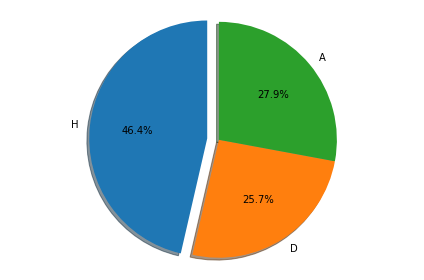

In [9]:
# make a pie plot to view the winning trend
labels = ['H', 'D', 'A']
sizes = [5931, 3283, 3568]
explode = (0.1, 0, 0)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

Glancing at data, below are observed
1. HomeTeam has an upper-hand in winning ~46%
2. There are Nan values in FTR (target value)
3. Date column and Categorical values - AwayTeam, HomeTeam, leage needs processing
4. test data in addition has index and referee columns

## Preprocessing

In [10]:
# remove the Nan values since they are meaningless
training_data = training_data.query('FTR in ("H", "D", "A")')

In [11]:
# create input and target data from training_data
X = training_data.drop('FTR', 1)
y = training_data['FTR']

In [12]:
# test data in addition has index and referee columns 
# since these are not part of training_data, the same is ignored
test_X = test_data
test_X = test_X.drop('index', axis=1)
test_X = test_X.drop('Referee', axis=1)

In [13]:
# create dummies for categorical data and modify date
def preprocess_data(X):
    categorical_features = []
    for col_label, col_data in X.iteritems():
        if col_data.dtype == object:
            categorical_features.append(col_label)
    X_modified = X
    X_modified = pd.get_dummies(X[categorical_features])
    X = X.join(X_modified)
    X = X.drop(categorical_features, axis=1)
    X = X.assign(day=X.Date.dt.day, 
                         month=X.Date.dt.month, 
                         year=X.Date.dt.year)
    X = X.drop('Date', axis=1)
    X.fillna(0, inplace=True)
    return X

In [14]:
X = preprocess_data(X)
test_X = preprocess_data(test_X)

In [15]:
# since pd.get_dummies creates dummy column for each variable, 
# there can be a mismatch in number of columns of training and test datasets
missing_cols_test = set(X.columns) - set(test_X.columns)
for missing_col in missing_cols_test:
    test_X[missing_col] = 0


missing_cols_train = set(test_X.columns) - set(X.columns)
for missing_col in missing_cols_train:
    X[missing_col] = 0

# this implies there are variables in testset which are not in training set
# so model is expected to predict on data which it has unseen which needs to fine tuned

## Training

In [16]:
# Shuffle and split the dataset into training and testing set.
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size = 1000,
                                                    random_state = 1,
                                                    stratify = y)

In [17]:
lr_model = LogisticRegression(random_state=1)
lr_model.fit(train_X, train_y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

## Prediction

In [18]:
lr_pred = lr_model.predict(val_X)
#accuracy = sum(val_y == lr_pred) / float(len(lr_pred))
#print(accuracy)
lr_f1_score = f1_score(val_y, lr_pred, pos_label='D', average='micro')
print(str.format("f1 score is {0}", str(lr_f1_score)))
test_pred = lr_model.predict(test_X)

f1 score is 0.646


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1052: UserWarning: Note that pos_label (set to 'D') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


## Fine Tuning

In [19]:
perm = PermutationImportance(lr_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.0706 ± 0.0145,HTAG
0.0694 ± 0.0142,HTHG
0.0490 ± 0.0068,HST
0.0470 ± 0.0236,AST
0.0066 ± 0.0064,AR
0.0020 ± 0.0018,AwayTeam_Villarreal
0.0020 ± 0.0000,AwayTeam_Atalanta
0.0018 ± 0.0059,league_la-liga
0.0018 ± 0.0008,HomeTeam_Inter
0.0018 ± 0.0023,HomeTeam_Lazio


From above, we notice that Half time values, Shots on targets followed by Red cards are weights more
Let's try to build a model with reduced features and use XGBoost for the same

In [20]:
new_features = ['HTAG', 'HTHG', 'HST', 'AST', 'AR', 'HR']
modified_X = training_data[new_features]
modified_y = training_data['FTR']
modified_test_X = test_data[new_features]

In [21]:
train_X_m, val_X_m, train_y_m, val_y_m = train_test_split(modified_X, modified_y, test_size = 1000,
                                                    random_state = 1,
                                                    stratify = modified_y)

In [22]:
xgb_model = xgb.XGBClassifier(random_state=1)
xgb_model.fit(train_X_m, train_y_m)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=1, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [23]:
xgb_pred = xgb_model.predict(val_X_m)
xgb_f1_score = f1_score(val_y_m, xgb_pred, pos_label='D', average='micro')
print(str.format("f1 score is {0}", str(xgb_f1_score)))
test_pred = xgb_model.predict(modified_test_X)

f1 score is 0.674


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1052: UserWarning: Note that pos_label (set to 'D') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


This updated model has a caveat that it doesn't make use of all features thereby some valid information might have been lost.
Also sklearn.encoder can be used and data can be analysed from that instead of pd.dummies as the later results in dummy columns in test data which are not present in training data